In [7]:
#!python -m pip install nidaqmx
import threading
import random
import time
from queue import Queue, Empty
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import nidaqmx
from nidaqmx.constants import LineGrouping
from nidaqmx.constants import AcquisitionType 
from nidaqmx.stream_readers import AnalogMultiChannelReader,AnalogSingleChannelReader
import os
from IPython.display import clear_output
from nidaqmx.constants import WAIT_INFINITELY
import re
import requests
import datetime
import json

In [8]:
deviceChannels=[]
for chan in ['N','W']:
    for index in range(8,0,-1):
        deviceChannels.append(chan+str(index))
for chan in ['E','S']:
    for index in range(1,9):
        deviceChannels.append(chan+str(index))

class Plater:
    def __init__(self,samplesPerSecond):
        self.samplesPerSec=samplesPerSecond
        
        self.channelMap = {}
        self.channels=[]
        
        logicMap ={}
        
        for i in range(0,16):
            res = [int(i)==1 for i in list('{0:04b}'.format(i))]
            logicMap[i] =res[::-1]
            
        cc=0
        for chan in ['W','N']:
            for index in range(1,9):
                outs = [False]*2
                if cc>15:
                    outs[0]=True
                    outs=np.concatenate([outs,logicMap[cc-16]])
                else:
                    outs[1]=True
                    outs=np.concatenate([outs,logicMap[cc]])
                self.channelMap[chan+str(index)]=outs
                self.channels.append(chan+str(index))
                cc+=1
        for chan in ['E','S']:
            for index in range(1,9):
                outs = [False]*2
                if cc>15:
                    outs[0]=True
                    outs=np.concatenate([outs,logicMap[cc-16]])
                else:
                    outs[1]=True
                    outs=np.concatenate([outs,logicMap[cc]])
                self.channelMap[chan+str(index)]=outs
                self.channels.append(chan+str(index))
                cc+=1
        self.start()
        
    def startPlayRecord(self):
        self.iMonTask = nidaqmx.Task(new_task_name ='iMonTask')
        self.biasTask = nidaqmx.Task(new_task_name ='biasTask')
        self.iMonTask.ai_channels.add_ai_voltage_chan("Dev1/ai6")
        self.iMonTask.ai_channels.add_ai_voltage_chan("Dev1/_ao0_vs_aognd")
        self.iMonTask.timing.cfg_samp_clk_timing(self.samplesPerSec, source="", sample_mode=AcquisitionType.CONTINUOUS, samps_per_chan=self.samplesPerSec)
        self.biasTask.ao_channels.add_ao_voltage_chan("Dev1/ao0")
        
    def start(self):
        
        self.startPlayRecord()
        self.muxTask = nidaqmx.Task(new_task_name ='muxTask')
        self.topBottomTask = nidaqmx.Task(new_task_name ='topBottomTask')
        self.resetTask = nidaqmx.Task(new_task_name ='resetTask')
        self.controlTask = nidaqmx.Task(new_task_name ='controlTask')
        
        self.icutTask  = nidaqmx.Task(new_task_name ='icutTask')
        self.muxTask.do_channels.add_do_chan("Dev1/port0/line2:7", line_grouping=LineGrouping.CHAN_PER_LINE)
        self.topBottomTask.do_channels.add_do_chan("Dev1/port0/line1", line_grouping=LineGrouping.CHAN_PER_LINE)
        self.resetTask.do_channels.add_do_chan("Dev1/port0/line0", line_grouping=LineGrouping.CHAN_PER_LINE)
        self.icutTask.ao_channels.add_ao_voltage_chan("Dev1/ao1")
         
        self.setBias(0)
        self.setThreshold(10)
        
    def __enter__(self):
        return self 
 
    def __exit__(self, *args):
        print('Closing tasks')
        self.setBias(0)
        self.setThreshold(0)
        self.iMonTask.close()
        self.muxTask.close()
        self.topBottomTask.close()
        self.resetTask.close()
        self.controlTask.close()
        self.biasTask.close()
        self.icutTask.close()

    def ResetDevice(self ):
        self.resetTask.write([True ], auto_start=True)
        time.sleep(.1)
        self.resetTask.write([False ], auto_start=True)

    def TopElectrode(self ):
        self.topBottomTask.write([True ], auto_start=True)
        time.sleep(.1)

    def BottomElectrode(self ):
        self.topBottomTask.write([False ], auto_start=True)
        time.sleep(.1)    

    def SelectChannel(self,channel ):
        self.muxTask.write(self.channelMap[channel], auto_start=True)
        time.sleep(.1)

    def setBias(self,bias ):
        self.biasTask.write([bias], auto_start=True)

      

    def setThreshold(self,current_nA ):
        bias = current_nA/50.0
        print('Thresh Current:' + str(current_nA) + 'nA', 'bias:' + str(bias) + 'V')
        self.icutTask.write([bias], auto_start=True)
        

        
    def disableThreshold(self):
        self.resetTask.write([True ], auto_start=True)
        
    def runConstantBias(self,bias_V, threshold_nA, maxTimeS,delayTimeS=1,resetToZero=True,samplesPerPoint=200):
        output = np.zeros([ samplesPerPoint])
        currents=[]
        times =[]
        starts = time.time()
        slew_V_s=1000/1000
        secPerSample=1.0/self.samplesPerSec*samplesPerPoint
        segmentTime = bias_V/slew_V_s
        segmentPoints =int( segmentTime/secPerSample)
        biasi =   np.linspace(0,bias_V,segmentPoints) 
        self.iMonTask.start()
        maxA=0
        self.setThreshold(current_nA = 50)
        for bias in biasi:
            self.setBias(bias)
            self.iMonReader.read_many_sample(data = output,number_of_samples_per_channel = samplesPerPoint)# read from DAQ
            maxA =np.max(output)*50
            times.append( time.time()- starts)
            currents.append(maxA)
            
        self.setBias(bias_V)
        startDelay = time.time()
        while (time.time()- startDelay)<delayTimeS:
            self.iMonReader.read_many_sample(data = output,number_of_samples_per_channel = samplesPerPoint)# read from DAQ
            maxA =np.max(output)*50
            times.append( time.time()- starts)
            currents.append(maxA)
            
        self.setThreshold(current_nA = threshold_nA)
        while (time.time()- starts)<maxTimeS and maxA<threshold_nA:
            self.iMonReader.read_many_sample(data = output,number_of_samples_per_channel = samplesPerPoint)# read from DAQ
            maxA =np.max(output)*50
            times.append( time.time()- starts)
            currents.append(maxA)
            
        self.iMonTask.stop()
        if resetToZero:
            self.setBias(0)
        currents=np.array(currents)
        clear_output(wait=True)
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.plot(times,currents, color=color)
        ax1.set_ylabel('Current (nA)', color=color)
        ax1.set_xlabel('Time (S)')
        fig.tight_layout() 
        plt.show()
        return maxA>threshold_nA,times,currents

    def runRT(self, voltage_mV, time_s):
        maxVoltage=voltage_mV/1000.0
        
        segmentPoints =int( time_s*self.samplesPerSec)
        biasi = np.zeros(segmentPoints)+maxVoltage
        
        outBias,currents=self.RunPlayRecord( biasi,time_s)
        
        conductance_nA= np.mean ( currents)/maxVoltage 
        
        return conductance_nA,  currents
    
    def RunPlayRecord(self, biasi,measureTime_s):
        totalPoints = int( self.samplesPerSec*measureTime_s )
        
        for task in (self.iMonTask, self.biasTask):
            task.timing.cfg_samp_clk_timing(
                rate=self.samplesPerSec, source="OnboardClock", samps_per_chan=totalPoints
            )

        # trigger write_task as soon as read_task starts
        self.biasTask.triggers.start_trigger.cfg_dig_edge_start_trig(
            self.iMonTask.triggers.start_trigger.term
        )
        
        # squeeze as Task.write expects 1d array for 1 channel
        self.biasTask.write(biasi , auto_start=False)
        # write_task doesn't start at read_task's start_trigger without this
        self.biasTask.start()
        # do not time out for long inputs
        currents = self.iMonTask.read(totalPoints, timeout=WAIT_INFINITELY)
        currents=np.asarray(currents)
        
        self.iMonTask.stop()
        self.biasTask.close()
        self.iMonTask.close()
        
        self.biasTask=None
        self.iMonTask=None
       
        
        self.startPlayRecord()
        return currents[1],currents[0]*50
        
    
    def runIV2(self, maxVoltage_mV, slew_mV_s , plot=False):
        slew_V_s=slew_mV_s/1000.0
        maxVoltage=maxVoltage_mV/1000.0
        
        segmentTime = maxVoltage/slew_V_s
       
        segmentPoints =int( segmentTime*self.samplesPerSec)
        biasi = np.concatenate( [np.linspace(0,maxVoltage,segmentPoints),np.linspace(maxVoltage,0,segmentPoints)])
         
        
        outBias,currents=self.RunPlayRecord( biasi,2*segmentTime)
        
        fBias, fCurrents =  outBias[:int(len(currents)/2)],currents[:int(len(currents)/2)]
        fBias, fCurrents =fBias[fCurrents<180],fCurrents[fCurrents<180]
        fBias, fCurrents =fBias[int(len(fBias)/2):],fCurrents[int(len(fBias)/2):]
        conductance_nA=np.polyfit(fBias,fCurrents,1)[0] 
        if plot:
            fig, ax1 = plt.subplots()
            color = 'tab:red'
            ax1.plot(outBias,currents, color=color)
            ax1.set_ylabel('Current (nA)', color=color)
            ax1.set_xlabel('Voltage (V)')

            fig.tight_layout() 
            plt.show()

           
            print(str(conductance_nA), 'nS')
        
        return conductance_nA, outBias,currents    
    
   
    
    def pulseBias(self,maxVoltage_mV, pulseLengthS,totalLengthS,numberPulses=1, plot=False ):
        maxVoltage=maxVoltage_mV/1000.0
        
        segmentPoints =int( totalLengthS*self.samplesPerSec)
        delay = int( self.samplesPerSec* (totalLengthS-pulseLengthS)/2.0)
        pulseSamples =int( self.samplesPerSec* pulseLengthS)
        
        biasi=[]
        for i in range(numberPulses):
            bias = np.zeros(segmentPoints)
            bias[delay:(delay+pulseSamples)]=maxVoltage
            biasi=np.concatenate([biasi,bias])
        
        outBias,currents=self.RunPlayRecord( biasi,totalLengthS*numberPulses)
        
        conductance_nA= np.mean ( currents [outBias>(maxVoltage/2.0)])/maxVoltage 
        
        if plot:
            fig, ax1 = plt.subplots()

            color = 'tab:red'
            ax1.set_xlabel('time (s)')
            ax1.set_ylabel('Bias (V)', color=color)
            ax1.plot(outBias, color=color)
            ax1.tick_params(axis='y', labelcolor=color)
            ax2 = ax1.twinx()  

            color = 'tab:blue'
            ax2.set_ylabel('Current (nA)', color=color) 
            ax2.plot(currents, color=color)
            ax2.tick_params(axis='y', labelcolor=color)
            fig.tight_layout()  # otherwise the right y-label is slightly clipped
            plt.show()
            print(str(conductance_nA), 'nS')
        return conductance_nA, outBias,currents    
        
        
    def runPulseTrain(self,maxVoltage_mV, pulseLengthS,totalLengthS, checkVoltage_mV, numberPulses=1, plot=False):
        
        self.setThreshold(current_nA = 50)
        plater.BottomElectrode()
        conductance_nA_B, _,currents_B=self.pulseBias( maxVoltage_mV=maxVoltage_mV, pulseLengthS = pulseLengthS,
                                                      totalLengthS=totalLengthS,numberPulses=numberPulses)
        
        plater.ResetDevice()
        plater.TopElectrode()
        conductance_nA_T, _,currents_T=self.pulseBias( maxVoltage_mV=maxVoltage_mV, pulseLengthS = pulseLengthS,
                                                      totalLengthS=totalLengthS,numberPulses=numberPulses)
        
        conductance_nA_IV, _,currents_IV=plater.runIV2( maxVoltage_mV=checkVoltage_mV, slew_mV_s=200,plot=plot)
        
        currents = np.concatenate([currents_B,currents_T,currents_IV])
        
        if plot:
            plt.plot( np.linspace(0,len(currents)/self.samplesPerSec ,len(currents)), currents)
            plt.ylabel('Current (nA)')
            plt.xlabel('Time (s)')
            plt.show()
        
        return conductance_nA_IV,[conductance_nA_B,conductance_nA_T],currents
    
    def runRamp(self, maxVoltage_mV,slew_mV_s):
        slew_V_s=slew_mV_s/1000.0
        maxVoltage=maxVoltage_mV/1000.0
       
        segmentTime = maxVoltage/slew_V_s
        segmentPoints =int( segmentTime*self.samplesPerSec)
        biasi = np.concatenate( [np.linspace(0,maxVoltage,segmentPoints)])
        
        outBias_R,currents_R=self.RunPlayRecord( biasi,segmentTime)
        return outBias_R,currents_R
        
        
    def runConstantBias2(self,maxVoltage_mV, threshold_nA, maxTime_S,
                         settleTime_S=.5,
                         slew_mV_s=1000,resetToZero=True, plot=False, junctionName=''):
       
        currents =[]
        starts = time.time()
        #first turn the threshold down to allow the ramp to get voltage up to the value
        self.setThreshold(current_nA = 50)
        if slew_mV_s>0:
            outBias_R,currents_R = self.runRamp(maxVoltage_mV, slew_mV_s)
            currents.append(currents_R)
        else:
            self.setBias(maxVoltage_mV/1000.0)
            
         
        
        if settleTime_S>0:
            conductance_nA, current_S = plater.runRT(voltage_mV=maxVoltage_mV, time_s=settleTime_S)
            currents.append(current_S)
        
        #turn down the threshold to do the deposition
        self.setThreshold(current_nA = threshold_nA)
        max_nA=0
        while (time.time()- starts)<maxTime_S and max_nA<threshold_nA:
            conductance_nA, current = plater.runRT(voltage_mV=maxVoltage_mV, time_s=1)
            max_nA =np.max(current) 
            currents.append(current)
            
        currents=np.concatenate(currents)
        
        if plot:
            clear_output()
            plt.title(junctionName)
            plt.plot( np.linspace(0,len(currents)/self.samplesPerSec, len(currents)), currents, label='Measure')
            if slew_mV_s>0:
                x=np.linspace(0,len(currents_R)/self.samplesPerSec, len(currents_R))
                plt.plot(x , currents_R,label='Ramp')
            else:
                x=[0]
                
            if settleTime_S>0:
                x=np.linspace(0,len(current_S)/self.samplesPerSec, len(current_S))+x[-1]
                plt.plot(x, current_S,label='Settle')
                
            plt.legend()
            plt.xlabel('Time (s)')
            plt.ylabel('Current (nA)')
            plt.show()
        
        if resetToZero:
            self.setBias(0)
            
        
        return max_nA>threshold_nA, currents    
                
    
#with Plater(10000) as plater:    
        #conductance_nA, outBias,currents=plater.runIV2( maxVoltage_mV=25, slew_mV_s=100)
        #conductance_nA, outBias,currents=plater.pulseBias( maxVoltage_mV=1000, pulseLengthS = .1,totalLengthS=.3)
        #plater.ResetDevice()
        #conductance_nA_IV,pulseConductance,currents=plater.runPulseTrain(maxVoltage_mV=1000,
        #                                                                 pulseLengthS = .1,
        #                                                                 totalLengthS=.3,
        #                                                                 checkVoltage_mV=100,
        #                                                                 numberPulses=10, plot=True )
        #conductance_nA, current = plater.runRT(voltage_mV=1000, time_s=3)
        #plater.setBias(0)
        #plater.TopElectrode()
        #plater.ResetDevice()
        #tripped, currents = plater. runConstantBias2(maxVoltage_mV=1000, threshold_nA=5, maxTime_S=8,plot=True)
        #print(tripped)
        
        

In [9]:
conductanceDatabase={}
 


In [10]:
wafer='P011'
chip ='E4'
stage ='Plating'
 


if stage not in conductanceDatabase:
    conductanceDatabase[stage + '_Before']={}
    conductanceDatabase[stage]={}


if os.path.exists(f'C:/Data/Plater/{wafer}')==False:
    os.mkdir(f'C:/Data/Plater/{wafer}')
if os.path.exists(f'C:/Data/Plater/{wafer}/{chip}')==False:    
    os.mkdir(f'C:/Data/Plater/{wafer}/{chip}')
    
channel='N8'    
filename=f'C:/Data/Plater/{wafer}/{chip}/{channel}_{stage}'
if os.path.exists(filename + '_initialIV.npy'):
    #raise Exception('Wrong Path')    
    pass


 
repeatChannels=[]

In [11]:
def Plate(parms,attempt,timeRun):
    #bias_V,threshold_nA,maxTimeS,settleTime_S,attempt,junctionName,bothElectrodes
    plater.setThreshold(current_nA = 200)
    plater.ResetDevice()
    plater.BottomElectrode()


    currents=[]
    start = time.time()
    for i in range(parms['platingAttempts']):
        plater.setBias(0)
        time.sleep(.5)
        if parms['pulsed']:
            conductance_nA_IV,_,curr=plater.runPulseTrain(maxVoltage_mV=parms['bias_V']*1000.0, pulseLengthS=.05,
                                                           totalLengthS=.1, checkVoltage_mV=100,
                                                           numberPulses=10, plot=True)

            print(conductance_nA_IV)
            tripped=conductance_nA_IV>parms['threshold_nA']
        else:
            if parms['bothElectrodes']:
                if (i+attempt)%2==0  :
                    plater.BottomElectrode()
                else:
                    plater.TopElectrode()
                    
                #if attempt>1:
                #    plater.ResetDevice()

            tripped, curr=plater.runConstantBias2(maxVoltage_mV=parms['bias_V']*1000.0,
                                                  threshold_nA=parms['threshold_nA'],
                                                  settleTime_S=parms['settleTime_S'],
                                                  maxTime_S=parms['maxTimeS'],plot=True,
                                                                  junctionName=parms['Device'])
            tripped = tripped or (np.max(curr)<-.1) or (np.max(curr)>50)

        print('Iteration',i)

        if len(currents)==0 :
            currents=curr
        else:
            currents=np.concatenate([currents,curr])

        if (time.time()-start>60*10):
            break
        if tripped :
            break

    timeRun = timeRun + (time.time()-start)
    with open(filename + f'_plate_{attempt}.npy', 'wb') as f:
        np.save(f, currents)
        
    return tripped,currents,timeRun

def SendInfo(info_JSON):
    r = requests.post('https://10.212.27.176:7006/AddDataPoint', json=info_JSON,verify=False)
    print(r)
     
    
    
def setParameters(channel):
    if channel.startswith('N'):
        bothElectrodes=False
        threshold_nA=5
        bias_V=0.95
        shortedThreshold_nS=8
        maxTimeS=8
        settleTime_S=1
        quickPulse =False
    elif channel.startswith('E'):
        bothElectrodes=True
        threshold_nA=5
        bias_V=0.95
        shortedThreshold_nS=8
        maxTimeS=8
        settleTime_S=1
        quickPulse =False
    elif channel.startswith('S'):
        bothElectrodes=False
        threshold_nA=5
        bias_V=1
        shortedThreshold_nS=8
        maxTimeS=8
        settleTime_S=1
        quickPulse =False
    elif channel.startswith('W'):
        bothElectrodes=True
        threshold_nA=5
        bias_V=1 
        shortedThreshold_nS=8
        maxTimeS=8
        settleTime_S=2
        quickPulse =False

    datafolder =f'//BIOD1633/Data/Plater/{wafer}/{chip}'
    infos={ "Wafer":wafer,
            "Chip":chip,
            "Device":channel,
            "Stage":stage,
            "Conductance":0,
            "Capacitance":0,
            "pulsed":False,
            "bothElectrodes":bothElectrodes,
            "threshold_nA":threshold_nA,
            "shortedThreshold_nS":shortedThreshold_nS,
            "maxTimeS":maxTimeS,
            "settleTime_S":settleTime_S,
            "quickPulse":quickPulse,
            "source":"Plater",
            "dataFolder":datafolder,
            "timestamp":str( datetime.datetime.now()),
            "bias":100,
            'finishThreshold_nA':4,
           'platingAttempts':75,
           'redoAfterIV':False,
            "bias_V":bias_V}    
    return infos
    
    

In [12]:

platingChannels = [x for x in deviceChannels]
platingChannels

['N8',
 'N7',
 'N6',
 'N5',
 'N4',
 'N3',
 'N2',
 'N1',
 'W8',
 'W7',
 'W6',
 'W5',
 'W4',
 'W3',
 'W2',
 'W1',
 'E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'E6',
 'E7',
 'E8',
 'S1',
 'S2',
 'S3',
 'S4',
 'S5',
 'S6',
 'S7',
 'S8']

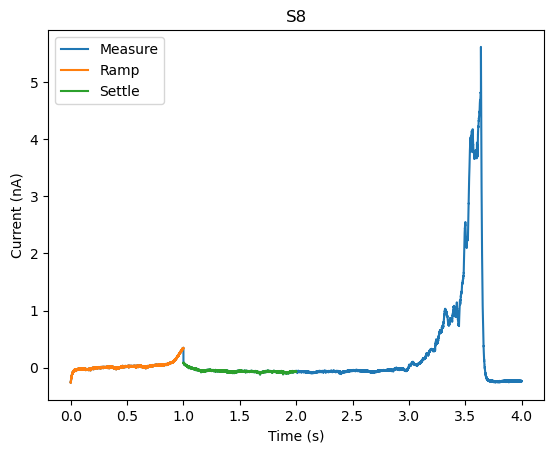

Iteration 47
Thresh Current:200nA bias:4.0V


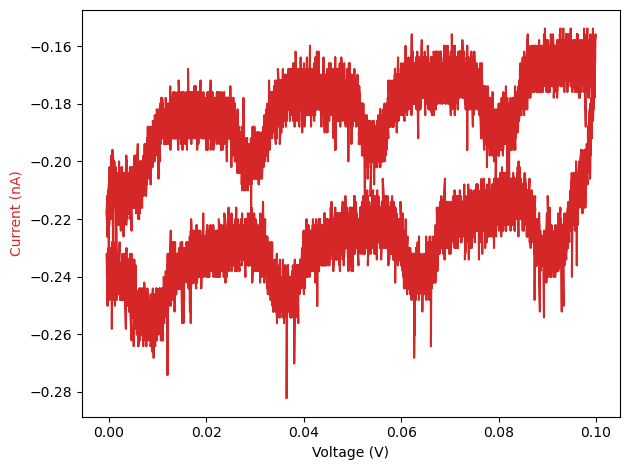

0.3496110273713695 nS
<Response [200]>
Closing tasks
Thresh Current:0nA bias:0.0V


C:\ProgramData\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.212.27.176'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Overtimed Channels
['N7', 'N6', 'N4', 'N3']


In [13]:
#########################################  Plating loop ##################################
stage ='Plating'
with Plater(10000) as plater:
    while len(platingChannels)>0:
        channel=  platingChannels.pop(0)
        infos = setParameters(channel)
        
        print(channel)
        plater.SelectChannel(channel)
        plater.setBias(0)
        plater.TopElectrode()
        plater.setThreshold(current_nA = 200)
        plater.ResetDevice()
        plater.disableThreshold()
        conductance_nA, outBias,currents =plater.runIV2( maxVoltage_mV=300, slew_mV_s=300, plot=True)
        
        conductanceDatabase[stage + '_Before'][channel]=conductance_nA
        
        filename=f'C:/Data/Plater/{wafer}/{chip}/{channel}_{stage}'
        with open(filename + '_BeforeIV.npy', 'wb') as f:
            np.save(f, conductance_nA)
            np.save(f, outBias)
            np.save(f, currents)
            
        infos['datafolder']=filename+ '_BeforeIV.npy'
        infos['Stage']=stage + '_Before'
        SendInfo(infos)

        if conductance_nA>infos['shortedThreshold_nS']:
            print('Shorted' + channel)   
            
            continue

        time.sleep(1)
        attempt =0
        start = time.time()
        timeRun=0
        while  conductance_nA<infos['finishThreshold_nA']*.9 and attempt<4 and (time.time()-start<60*10):
            
            #if (attempt==0 and infos['quickPulse']):#
            #    conductance_nA_IV,_,curr=plater.runPulseTrain(maxVoltage_mV=infos['bias_V']*1000.0, pulseLengthS=.05,
            #                                               totalLengthS=.1, checkVoltage_mV=100,
            #                                               numberPulses=3, plot=True)                
            #    plater.ResetDevice()
                
            tripped,currents0,timeRun=Plate(infos,attempt,timeRun)
            plater.setBias(0)
            
            plater.TopElectrode()
            plater.setThreshold(current_nA = 200)
            plater.disableThreshold()
            time.sleep(5)
            
            if infos['redoAfterIV']==False:
                conductance_nA, outBias,currents =plater.runIV2( maxVoltage_mV=100, slew_mV_s=100,plot=True)
                break
            else:
                conductance_nA, outBias,currents =plater.runIV2( maxVoltage_mV=300, slew_mV_s=300,plot=True)
                
            print(channel)
            print('attempt',attempt)
            print('RunTime', timeRun)
            for p in infos:
                print(p, infos[p])
                  
            if tripped ==False:
                break
            if np.max(currents)>50:
                break
            
                
            attempt+=1
            
            

        conductanceDatabase[stage ][channel]=conductance_nA

        #write out the parameters for this channel for later checks
        json_object = json.dumps(infos, indent = 4) 
        with open(filename + '_parameters.json', 'w') as f:
            f.write(json_object)
            
        #store channels that are are opened for another round
        if (time.time()-start>60*10):
            repeatChannels.append(channel)
            
        with open(filename + '_IV.npy', 'wb') as f:
            np.save(f, conductance_nA)
            np.save(f, outBias)
            np.save(f, currents)
            
        infos['datafolder']=filename+ '_IV.npy'
        infos['Stage']=stage 
        SendInfo(infos)            

        plater.setBias(0)
        
print('Overtimed Channels')        
print(repeatChannels)        

Thresh Current:10nA bias:0.2V
Thresh Current:200nA bias:4.0V
W1


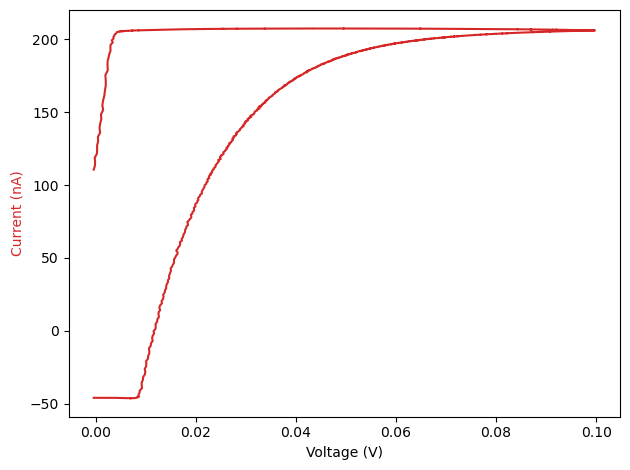

3661.406962330016 nS
W2


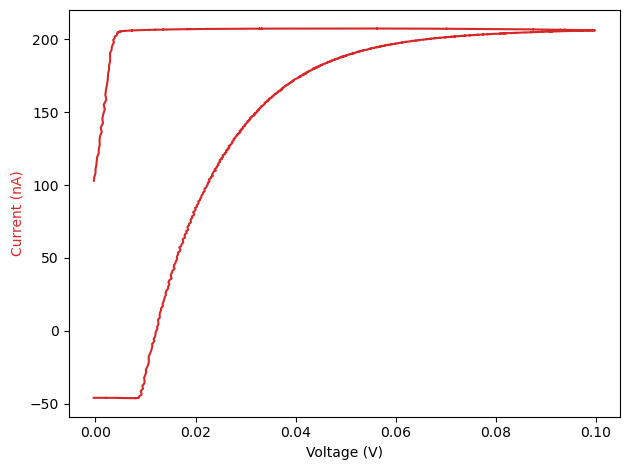

3713.018503252562 nS
W3


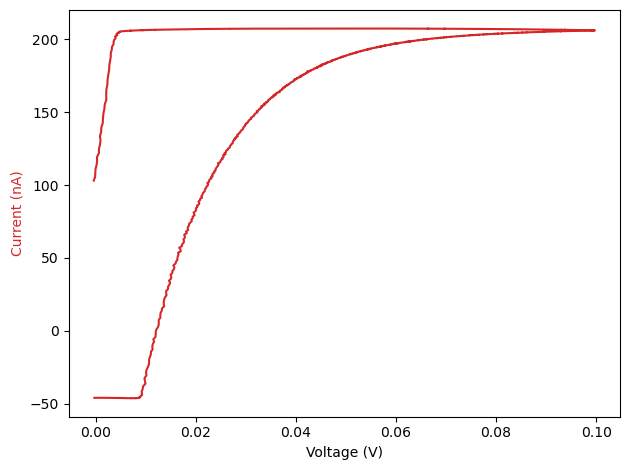

3717.4845039817287 nS
W4


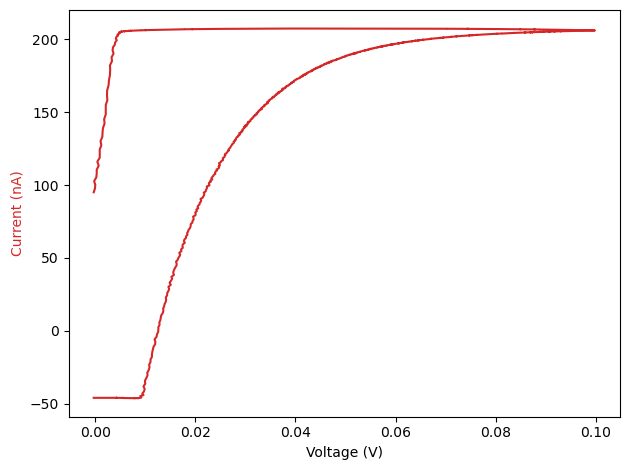

3732.3649528811948 nS
W5


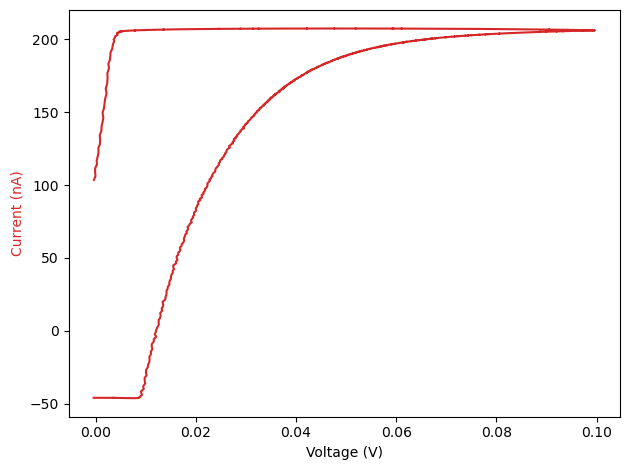

3723.6836205533573 nS
W6


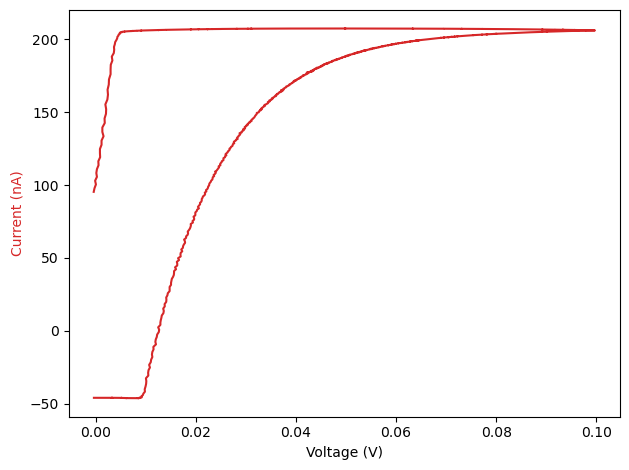

3737.7797522251913 nS
W7


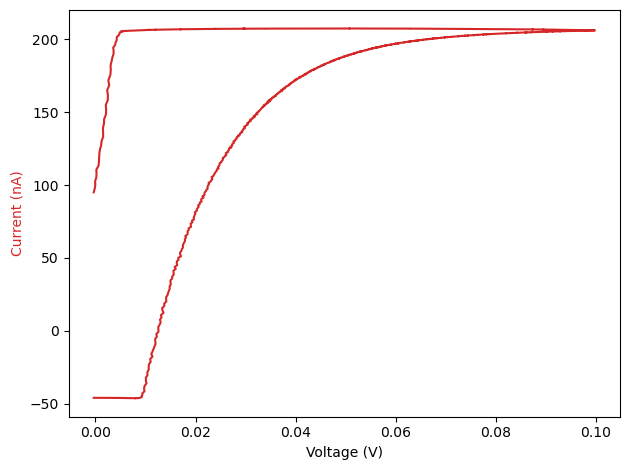

3737.796844663173 nS
W8


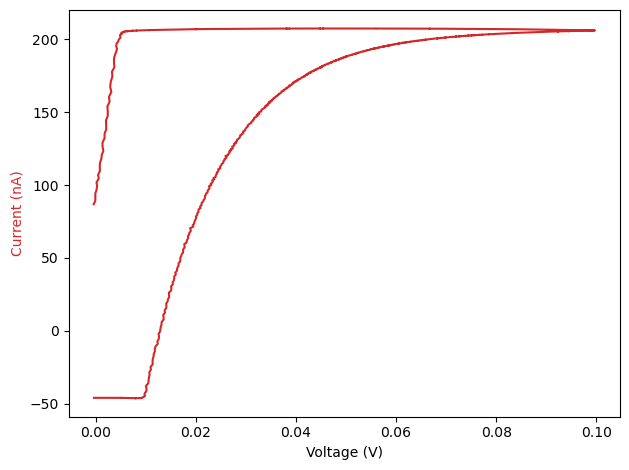

3763.7341999690293 nS
N1


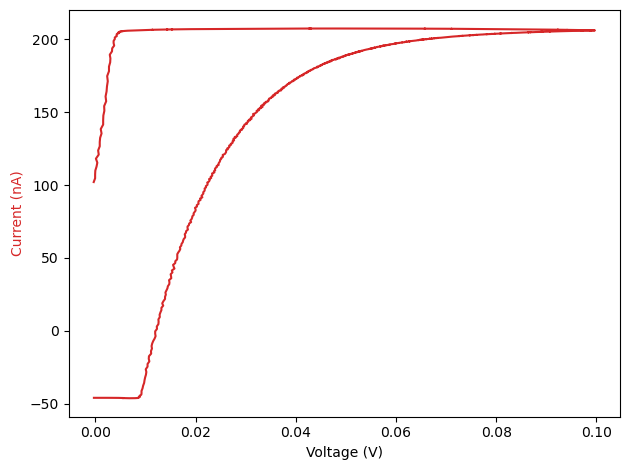

3712.6636258672884 nS
N2


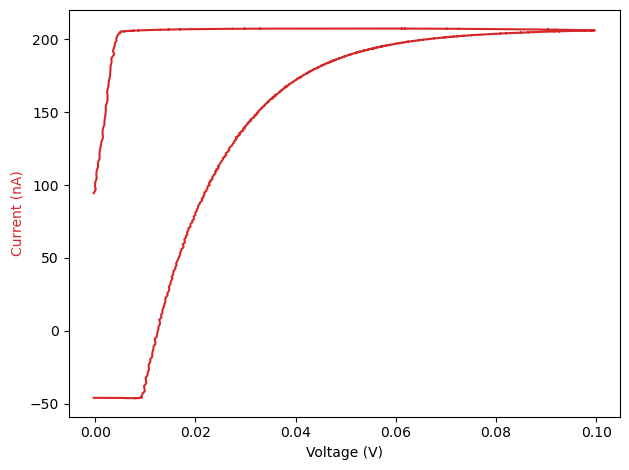

3738.879581422884 nS
N3


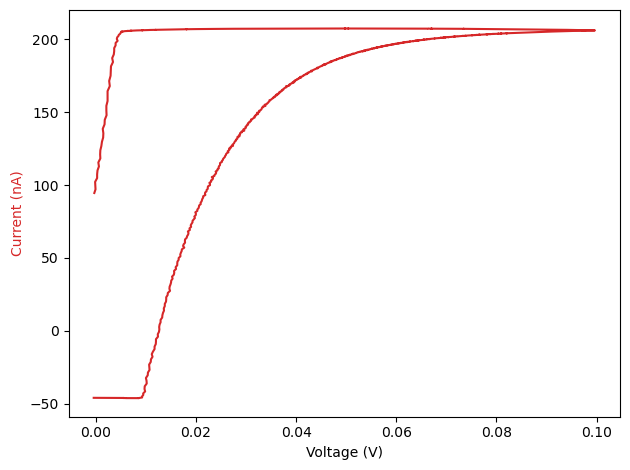

3734.867838600478 nS
N4


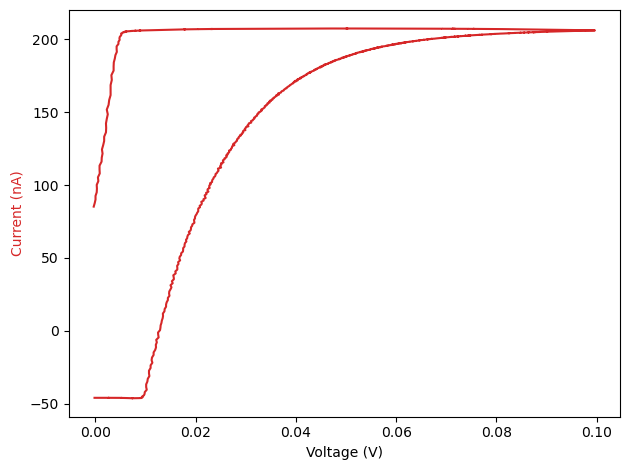

3759.803112942958 nS
N5


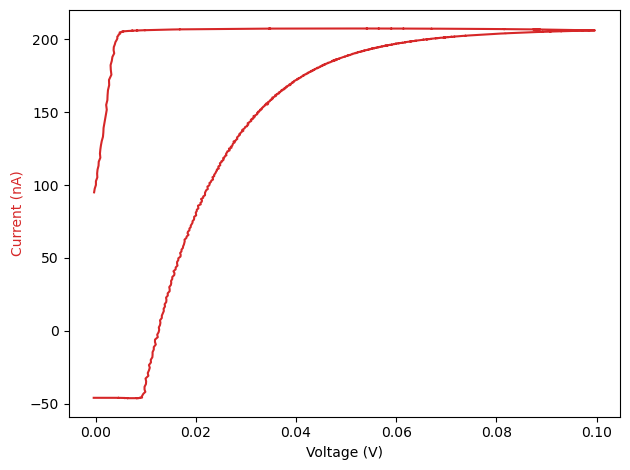

3733.9626827181587 nS
N6


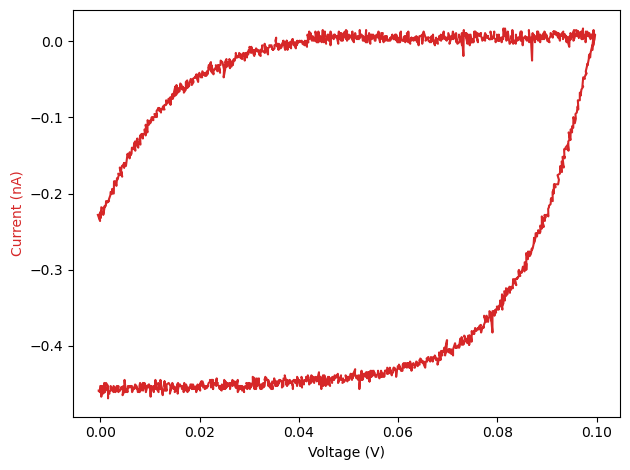

0.043796148813532255 nS
N7


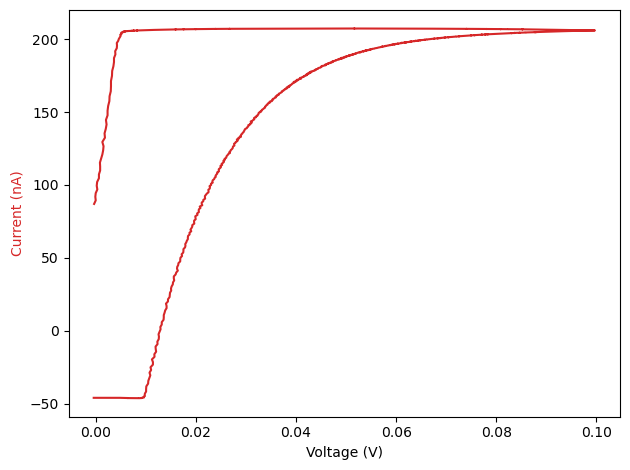

3765.731012201688 nS
N8


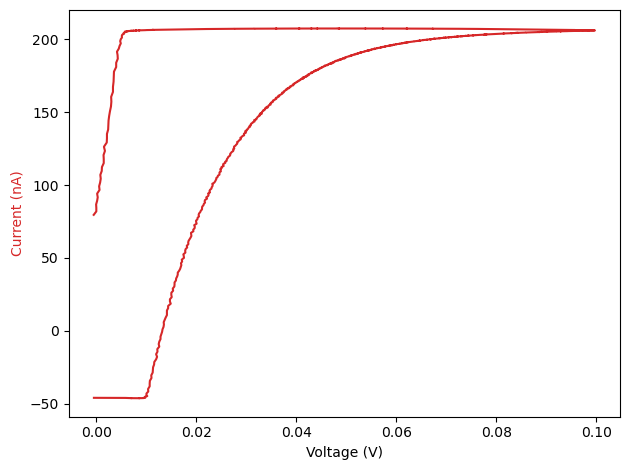

3807.6406202363805 nS
E1


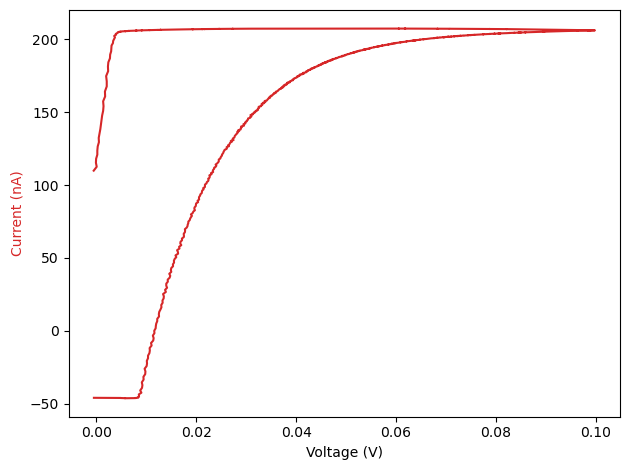

3704.4961442756803 nS
E2


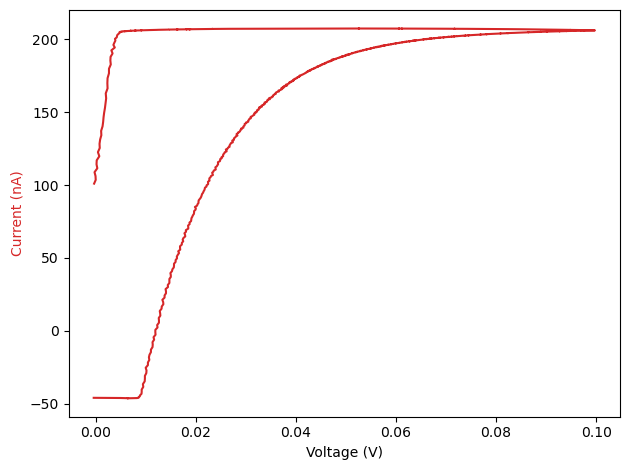

3710.553567266456 nS
E3


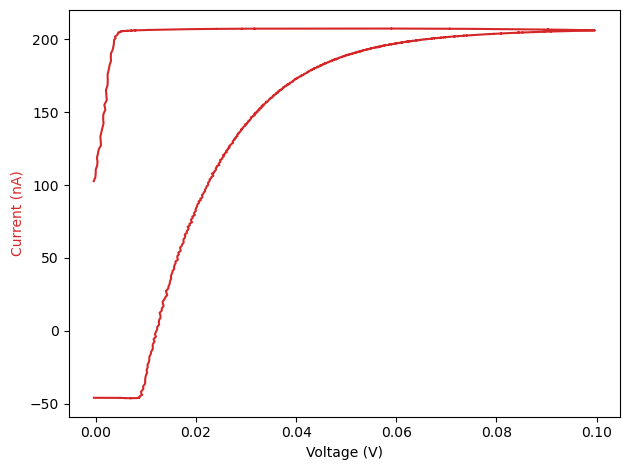

3718.5736810679973 nS
E4


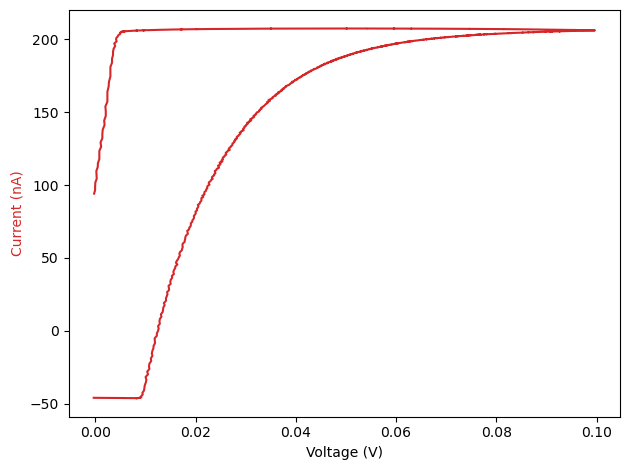

3754.2816611029884 nS
E5


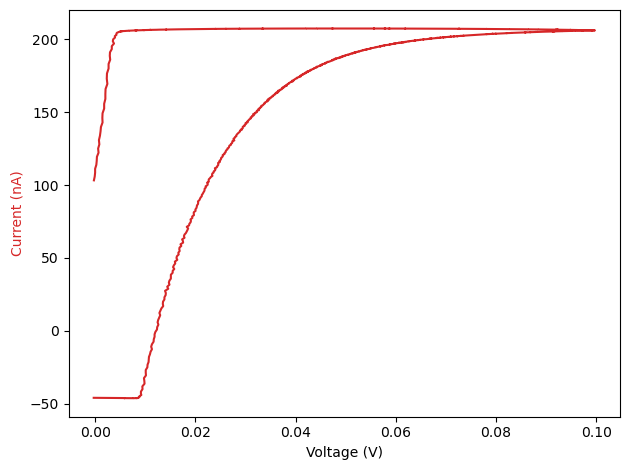

3718.84118581991 nS
E6


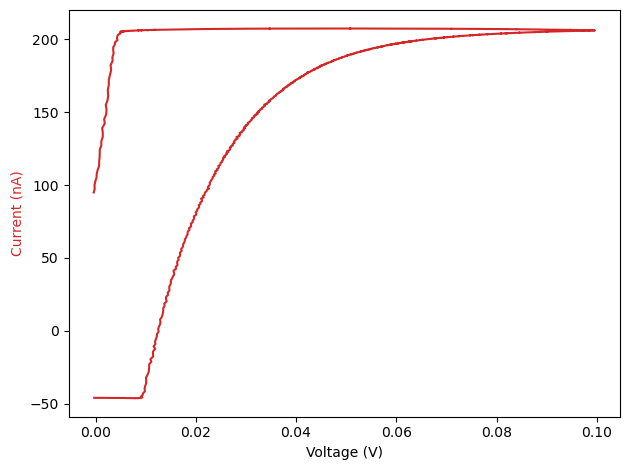

3761.3099708409077 nS
E7


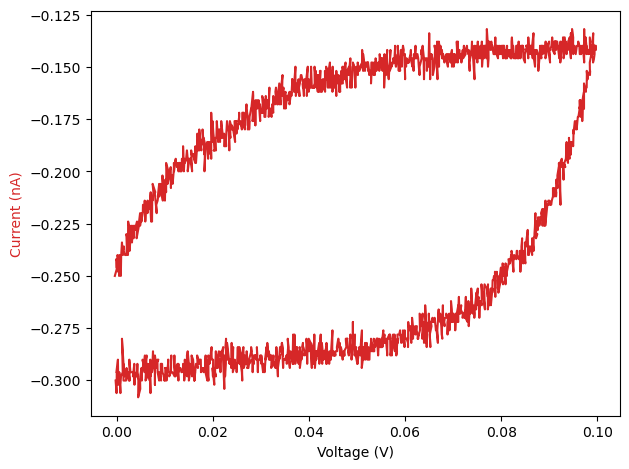

0.20519175449528984 nS
E8


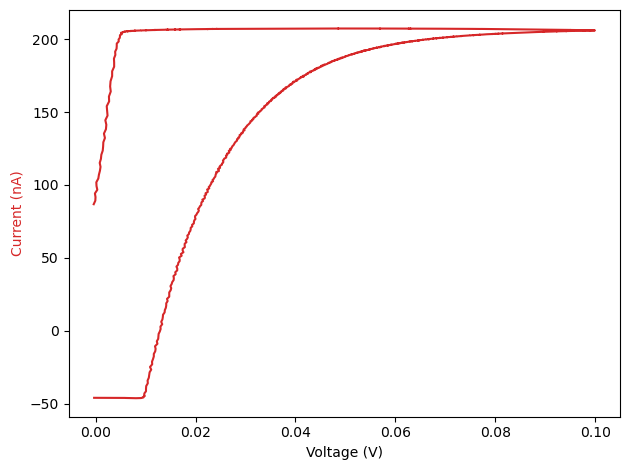

3774.422328938171 nS
S1


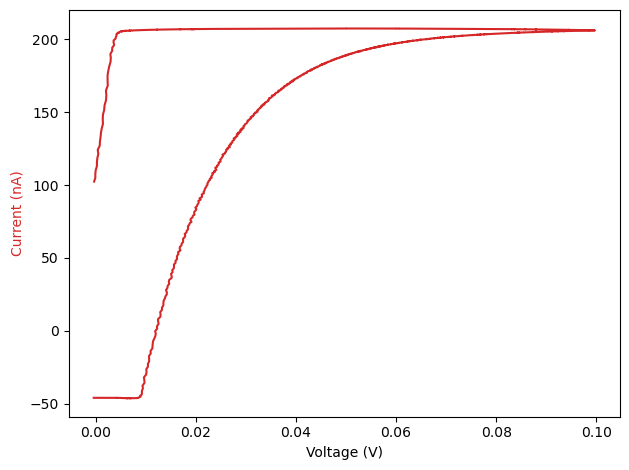

3720.9459701024584 nS
S2


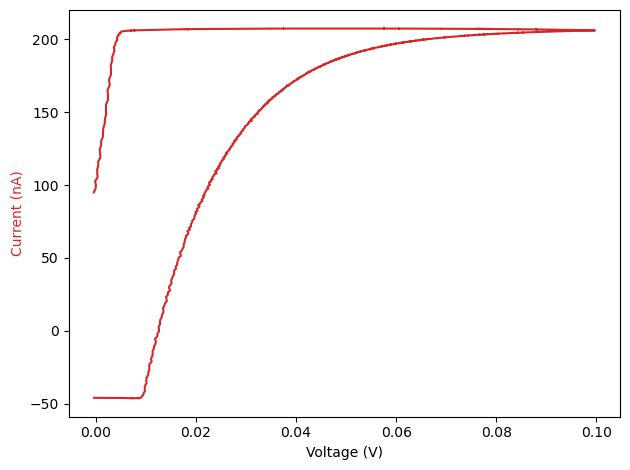

3758.019166193669 nS
S3


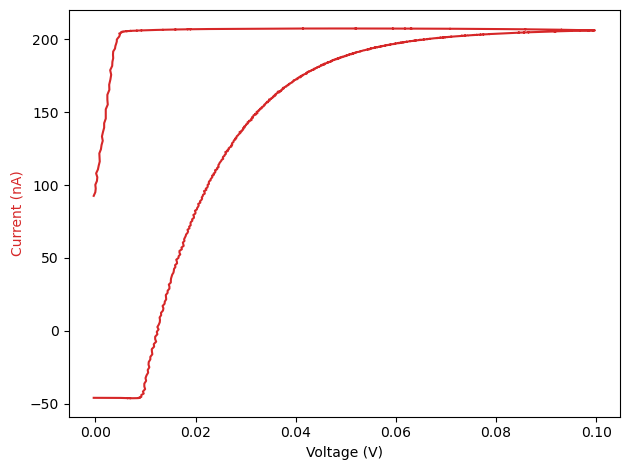

3741.1107671806267 nS
S4


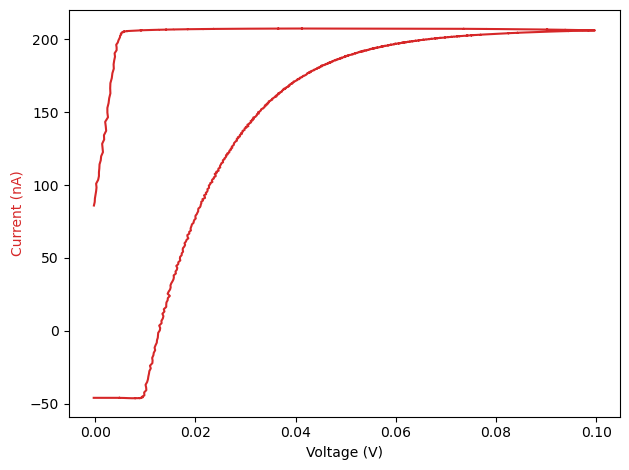

3765.1540706615438 nS
S5


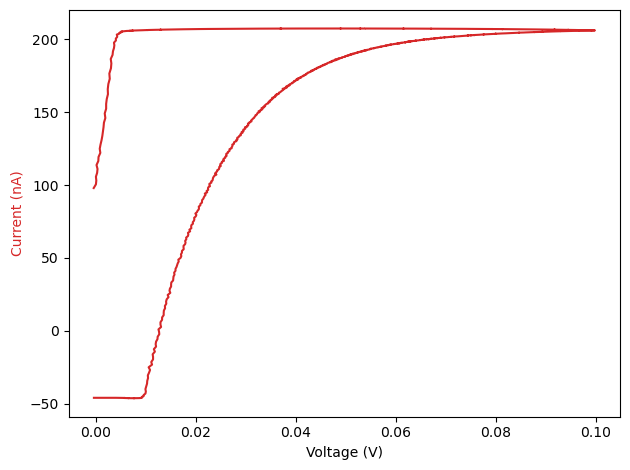

3768.4033725064796 nS
S6


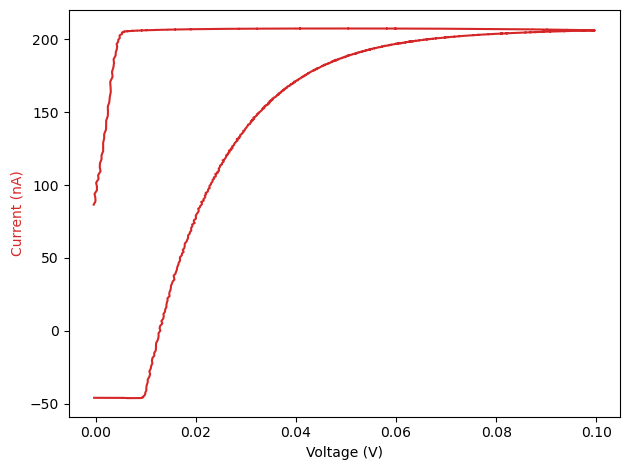

3764.888666972203 nS
S7


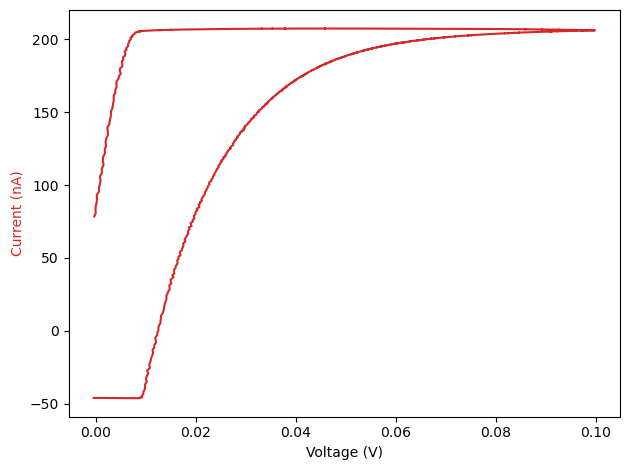

3746.633251793183 nS
S8


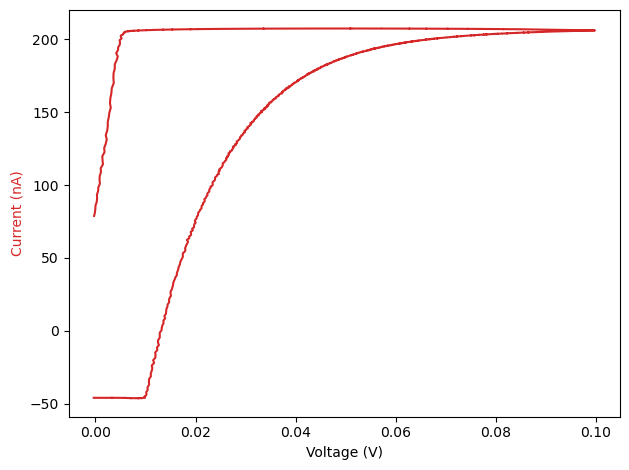

3793.1030726597096 nS
Closing tasks
Thresh Current:0nA bias:0.0V


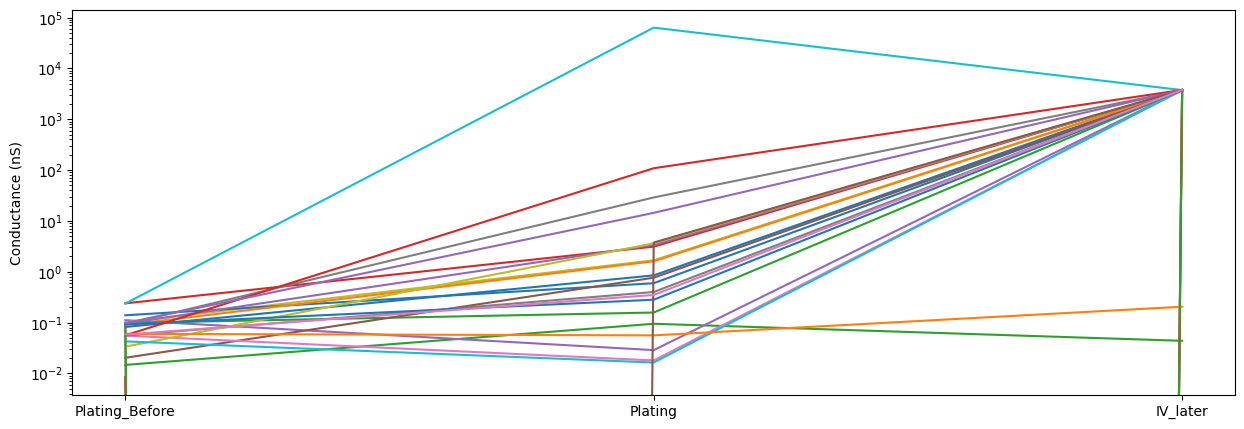

In [14]:
#########################################  Perform just the IV ##################################
numberScans=1
for i in range(numberScans):
    stage ='IV_later'
    rtBias_mV = 100

    if os.path.exists(f'C:/Data/Plater/{wafer}')==False:
        os.mkdir(f'C:/Data/Plater/{wafer}')
    if os.path.exists(f'C:/Data/Plater/{wafer}/{chip}')==False:    
        os.mkdir(f'C:/Data/Plater/{wafer}/{chip}')

    channel='N8'    
    filename=f'C:/Data/Plater/{wafer}/{chip}/{channel}_{stage}'
    if os.path.exists(filename + '.npy'):
        raise Exception('Wrong Path')    
        pass


    with Plater(10000) as plater:
            plater.setBias(0)
            plater.TopElectrode()
            #plater.BottomElectrode()

            plater.setThreshold(current_nA = 200)
            plater.disableThreshold()

            for channel in plater.channels:
                print(channel)
                plater.setBias(0)
                plater.SelectChannel(channel)
                time.sleep(1)

                filename=f'C:/Data/Plater/{wafer}/{chip}/{channel}_{stage}'

                if False:
                    conductance_nA, current = plater.runRT(voltage_mV=rtBias_mV, time_s=3,plot=True)
                    plt.plot(currents)
                    plt.show()
                    with open(filename+ '_RT.npy', 'wb') as f:
                        np.save(f, rtBias_mV)
                        np.save(f, currents)


                conductance_nA, outBias,currents =plater.runIV2( maxVoltage_mV=rtBias_mV, slew_mV_s=1200,plot=True)

                plater.setBias(0)
                if stage not in conductanceDatabase:
                    conductanceDatabase[stage]={}

                conductanceDatabase[stage ][channel]=conductance_nA

                with open(filename+ '_IV.npy', 'wb') as f:
                    np.save(f, conductance_nA)
                    np.save(f, outBias)
                    np.save(f, currents)
                
                
    stages =[]
    channelValues ={}
    for trial in conductanceDatabase:
        #if 'Plating' in trial:
        #    continue
        channelConds = conductanceDatabase[trial]
        for channel in channelConds:
            if trial not in stages:
                stages.append(trial)
            if channel not in channelValues:
                channelValues[channel]=[]
            cond = channelConds[channel]
            channelValues[channel].append(cond)

    plt.figure(figsize=(15,5))        
    for channel in channelValues:
        try:
            plt.semilogy( stages,channelValues[channel],label=channel)
        except:
            pass
    plt.ylabel('Conductance (nS)')
    plt.show()
            
    if numberScans>1:
        for j in range(60*3):
            time.sleep(20)

Thresh Current:10nA bias:0.2V
Thresh Current:200nA bias:4.0V
N1


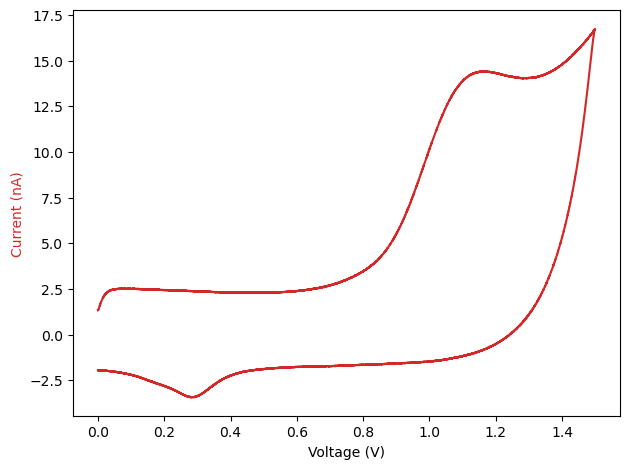

18.60128680339281 nS
N7


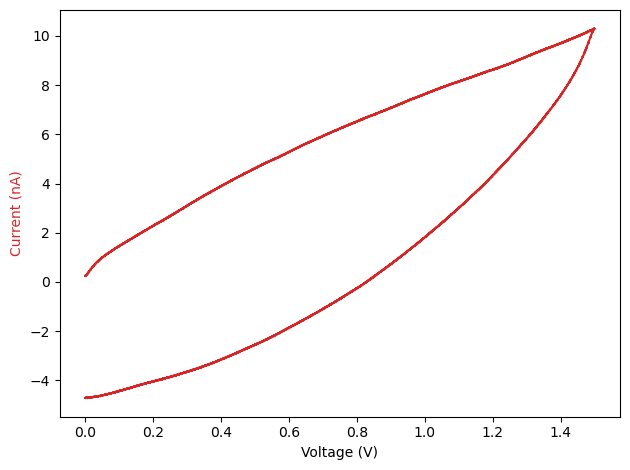

5.271346404736682 nS
S1


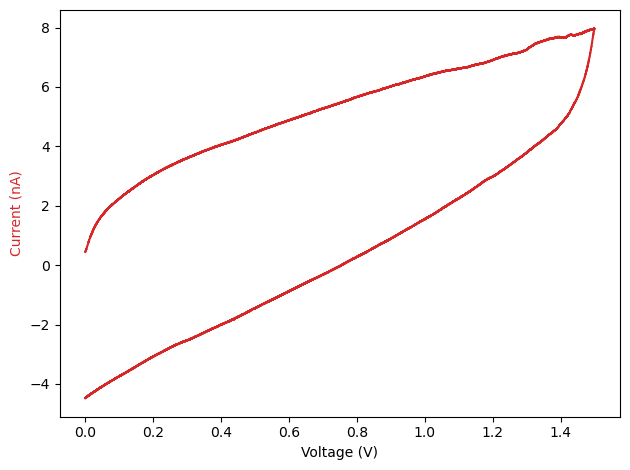

3.271310739688235 nS
S7


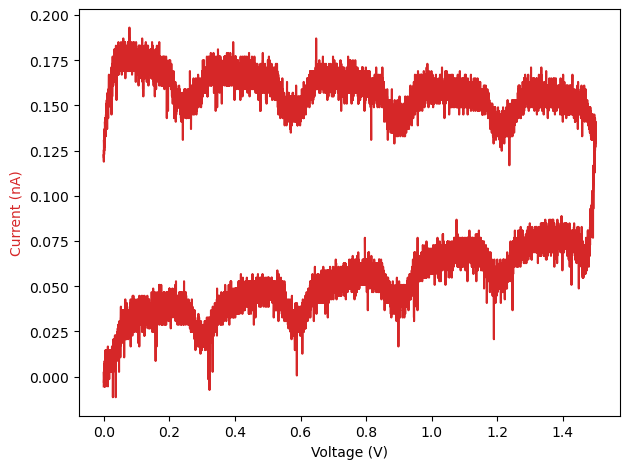

-0.01047865554925543 nS
E1


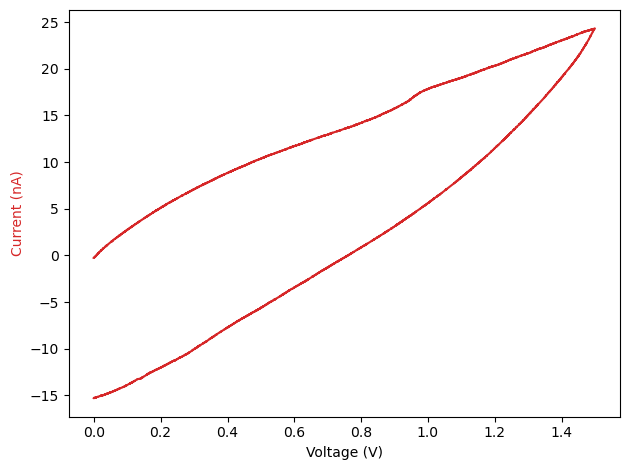

14.447759475094154 nS
W1


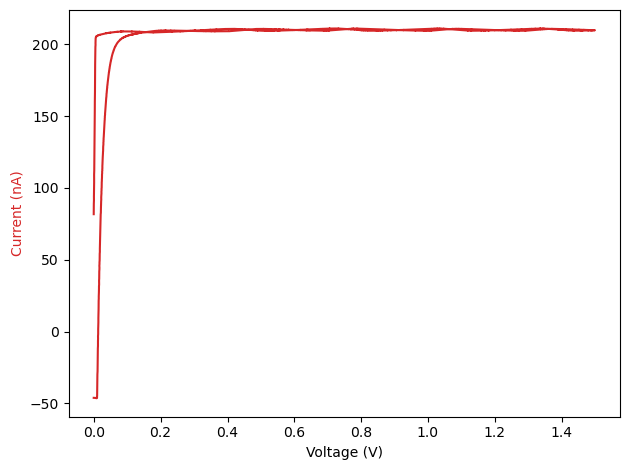

3679.9127980979683 nS
W4


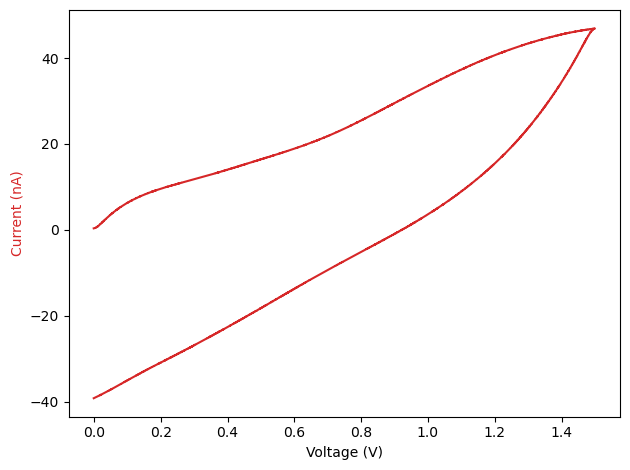

32.5549046858639 nS
Closing tasks
Thresh Current:0nA bias:0.0V


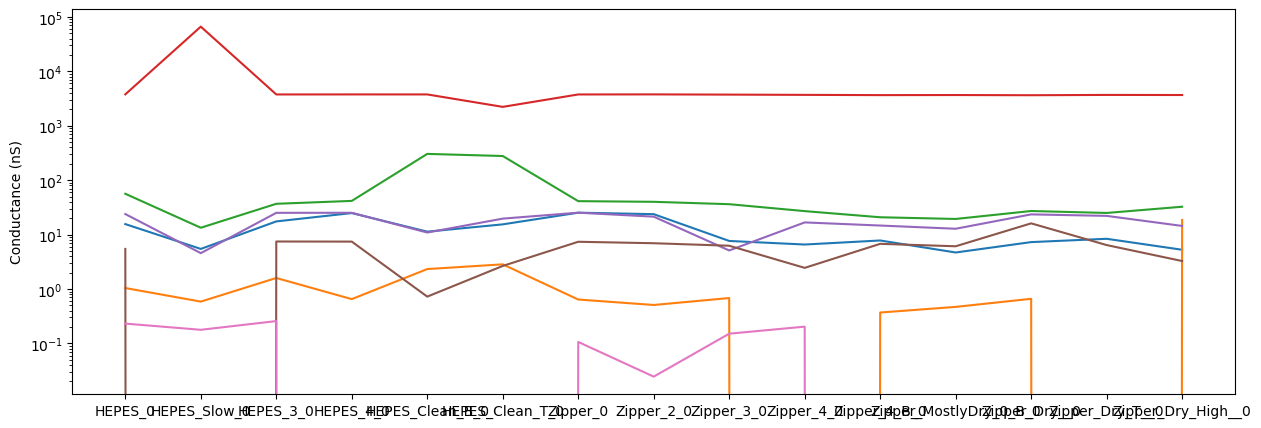

In [22]:
numberScans=1
for i in range(numberScans):
    stage ='Zipper_Dry_High_' + '_'+ str(i)
    rtBias_mV = 1500

    if os.path.exists(f'C:/Data/Plater/{wafer}')==False:
        os.mkdir(f'C:/Data/Plater/{wafer}')
    if os.path.exists(f'C:/Data/Plater/{wafer}/{chip}')==False:    
        os.mkdir(f'C:/Data/Plater/{wafer}/{chip}')

    channel='N8'    
    filename=f'C:/Data/Plater/{wafer}/{chip}/{channel}_{stage}'
    if os.path.exists(filename + '.npy'):
        raise Exception('Wrong Path')    
        pass


    with Plater(10000) as plater:
            plater.setBias(0)
            plater.TopElectrode()
            #plater.BottomElectrode()

            plater.setThreshold(current_nA = 200)
            plater.disableThreshold()

            for channel in ['N1','N7','S1','S7','E1','W1','W4']:
                print(channel)
                plater.setBias(0)
                plater.SelectChannel(channel)
                time.sleep(1)

                filename=f'C:/Data/Plater/{wafer}/{chip}/{channel}_{stage}'

                if False:
                    conductance_nA, current = plater.runRT(voltage_mV=rtBias_mV, time_s=3,plot=True)
                    plt.plot(currents)
                    plt.show()
                    with open(filename+ '_RT.npy', 'wb') as f:
                        np.save(f, rtBias_mV)
                        np.save(f, currents)


                conductance_nA, outBias,currents =plater.runIV2( maxVoltage_mV=rtBias_mV, slew_mV_s=1200,plot=True)

                plater.setBias(0)
                if stage not in conductanceDatabase:
                    conductanceDatabase[stage]={}

                conductanceDatabase[stage ][channel]=conductance_nA

                with open(filename+ '_IV.npy', 'wb') as f:
                    np.save(f, conductance_nA)
                    np.save(f, outBias)
                    np.save(f, currents)
                
                
    stages =[]
    channelValues ={}
    for trial in conductanceDatabase:
        #if 'Plating' in trial:
        #    continue
        channelConds = conductanceDatabase[trial]
        for channel in channelConds:
            if trial not in stages:
                stages.append(trial)
            if channel not in channelValues:
                channelValues[channel]=[]
            cond = channelConds[channel]
            channelValues[channel].append(cond)

    plt.figure(figsize=(15,5))        
    for channel in channelValues:
        try:
            plt.semilogy( stages,channelValues[channel],label=channel)
        except:
            pass
    plt.ylabel('Conductance (nS)')
    plt.show()
            
    if numberScans>1:
        for j in range(60*3):
            time.sleep(20)

In [ ]:
stages =[]
channelValues ={}
for trial in conductanceDatabase:
    #if 'Plating' in trial:
    #    continue
    channelConds = conductanceDatabase[trial]
    for channel in channelConds:
        if trial not in stages:
            stages.append(trial)
        if channel not in channelValues:
            channelValues[channel]=[]
        cond = channelConds[channel]
        channelValues[channel].append(cond)
        
plt.figure(figsize=(15,5))        
for channel in channelValues:
    try:
        plt.plot( stages,channelValues[channel],label=channel)
    except:
        pass
plt.ylim([0, 50])    
plt.ylabel('Conductance (nS)')
plt.show()

In [2]:
import os
os.getcwd()

'C:\\DEMP'

In [ ]:
folder= f'C:/Data/Plater/{wafer}/{chip}'
files = os.listdir( folder  )
for channel in plater.channels:
    cFiles = [file for file in files if channel in file and ('HEPES_' in file or 'HEPES3_' in file or 'BSA_Dry' in file)]
    for file in cFiles:
        label="_".join(file.split('_')[1:-1])
        print(label)
        with open(folder+'/'+file, 'rb') as f:
            slope=np.load(f)
            outBias=np.load(f)
            current=np.load(f)
        plt.plot(outBias,current,label=label)
    plt.title(channel)
    plt.legend()   
    plt.show()
    
    

In [ ]:
import pyvisa
import time
import numpy as np
import matplotlib.pyplot as plt
rm = pyvisa.ResourceManager()
print(rm.list_resources())

keithley = rm.open_resource("TCPIP0::129.219.2.85::5025::SOCKET")
print('\n Open Successful!')
keithley.read_termination = '\n'
keithley.write_termination = '\n'

code ="""
reset()
loadscript
    
    
    numCycles=2
    frequency=45
    limitI=10e-6

	local COMPLETE = "{COMPLETE}"
	-- Generate the source values
	local Vpp				= .2
	local sourceValues		= {} 
	local pointsPerCycle	= 7200 / frequency
	local numDataPoints		= pointsPerCycle * numCycles

	local res = {}
    for i = 1, numDataPoints do
        res[i] =math.abs( math.sin(i * 2 * math.pi / pointsPerCycle))
        sourceValues[i] = (Vpp * res[i])  
    end

	-- Configure the SMU ranges
	smua.reset()
	smua.source.settling		= smua.SETTLE_FAST_POLARITY
	smua.source.autorangev		= smua.AUTORANGE_OFF
	smua.source.autorangei		= smua.AUTORANGE_OFF
    smua.source.rangev			= math.abs( Vpp ) +.01
	smua.source.delay			= 0
	smua.source.limiti			= 1e-3

	smua.measure.autorangev		= smua.AUTORANGE_OFF
	smua.measure.autorangei		= smua.AUTORANGE_OFF
	smua.measure.autozero		= smua.AUTOZERO_OFF
	smua.measure.delay			= 0
	smua.measure.delayfactor    = 1
	smua.measure.analogfilter   = 0

	-- Voltage will be measured on the same range as the source range
	smua.measure.rangei			= limitI
	smua.measure.nplc			= 0.001

	-- Prepare the Reading Buffers
	smua.nvbuffer1.clear()
	smua.nvbuffer1.collecttimestamps	= 1
	smua.nvbuffer2.clear()
	smua.nvbuffer2.collecttimestamps	= 1

	-- Configure the trigger model
	--============================
	
	-- Timer 1 controls the time between source points
	trigger.timer[1].delay = (1 / 7200)
	trigger.timer[1].passthrough = true
	trigger.timer[1].stimulus = smua.trigger.ARMED_EVENT_ID
	trigger.timer[1].count = numDataPoints - 1

	-- Configure the SMU trigger model
	smua.trigger.source.listv(sourceValues)
	smua.trigger.source.limiti		= limitI
	smua.trigger.measure.action		= smua.ENABLE
	smua.trigger.measure.iv(smua.nvbuffer1, smua.nvbuffer2)
	smua.trigger.endpulse.action	= smua.SOURCE_HOLD
	smua.trigger.endsweep.action	= smua.SOURCE_IDLE
	smua.trigger.count				= numDataPoints
	smua.trigger.arm.stimulus		= 0
	smua.trigger.source.stimulus	= trigger.timer[1].EVENT_ID
	smua.trigger.measure.stimulus	= 0
	smua.trigger.endpulse.stimulus	= 0
	smua.trigger.source.action		= smua.ENABLE
	-- Ready to begin the test

	smua.source.output					= smua.OUTPUT_ON
	-- Start the trigger model execution
	smua.trigger.initiate()
	-- Wait until the sweep has completed
	waitcomplete()
	smua.source.output					= smua.OUTPUT_OFF

 
	printbuffer(1, smua.nvbuffer1.n, smua.nvbuffer1.readings)
	print('')
    printbuffer(1, smua.nvbuffer2.n, smua.nvbuffer2.readings)

	print('Done')
endscript
script.run()
""".split('\n')

keithley.query("print('h')")
def KeithleyIV():
    for line in code:
        keithley.write(line)

    time.sleep(2)
    text=keithley.read()
    while 'Done' not in text :
        text+=keithley.read() + "\n"

    text = text.split('\n') 
    current = np.array( [float(x) for x in text[0].split(',')[:-1]])
    volts  = np.array( [float(x) for x in text[1].split(',')[:-1]])
    plt.plot(volts,current)
    plt.show()
    slope=np.polyfit(volts,current,1)[0]
    
    return slope,volts,current*1e9

In [ ]:
#########################################  Perform just the IV ##################################
stage ='DNA_2K_L'
rtBias_mV = 50

if os.path.exists(f'C:/Data/Plater/{wafer}')==False:
    os.mkdir(f'C:/Data/Plater/{wafer}')
if os.path.exists(f'C:/Data/Plater/{wafer}/{chip}')==False:    
    os.mkdir(f'C:/Data/Plater/{wafer}/{chip}')

channel='N8'    
filename=f'C:/Data/Plater/{wafer}/{chip}/{channel}_{stage}'
if os.path.exists(filename + '.npy'):
    raise Exception('Wrong Path')    
    pass

with Plater(10000) as plater:
        plater.setBias(0)
        plater.TopElectrode()
        
        plater.setThreshold(current_nA = 200)
        plater.disableThreshold()

        for channel in plater.channels:
            print(channel)
            plater.setBias(0)
            plater.SelectChannel(channel)
            time.sleep(1)
            
            filename=f'C:/Data/Plater/{wafer}/{chip}/{channel}_{stage}'
            slope, outBias,currents =KeithleyIV()
            plater.setBias(0)
            
            
            with open(filename+ '_KIV.npy', 'wb') as f:
                np.save(f, slope)
                np.save(f, outBias)
                np.save(f, currents)

In [ ]:

with Plater(10000) as plater:
        plater.setBias(0)
        plater.TopElectrode()
        
        plater.setThreshold(current_nA = 200)
        plater.disableThreshold()

        for channel in plater.channels:
            plater.setBias(0)
            plater.SelectChannel(channel)
            time.sleep(1)
            plater.TopElectrode()
            times,currents=plater.runRT(voltage_mV=100,time_s= 3)
            plt.plot(currents)
            
            plater.BottomElectrode()
            times,currents=plater.runRT(voltage_mV=100,time_s= 3)
            plt.plot(currents)
            
            plt.show()
            
            plater.TopElectrode()
            slope, outBias,currents =plater.runIV(maxVoltage=.25,slew_mV_s=1000, samplesPerPoint=200)
             
            
            plater.BottomElectrode()
            slope, outBias,currents =plater.runIV(maxVoltage=.25,slew_mV_s=1000, samplesPerPoint=200)
             
            
            
            
            break
            

In [23]:
plater = Plater(10000)
plater.setBias(0)
plater.TopElectrode()
#plater.BottomElectrode()

plater.setThreshold(current_nA = 200)
plater.disableThreshold()

            
plater.setBias(1)
plater.SelectChannel('N1')

Thresh Current:10nA bias:0.2V
Thresh Current:200nA bias:4.0V


In [32]:
plater.setBias(1)
plater.ResetDevice()
plater.SelectChannel('E8')

In [ ]:
N1->W8
N8->W1
W8->N1
W1->N8


